In [4]:
import json
import os

# Define the base directory for the problem files
problem_dir = "math-rollouts/deepseek-r1-distill-llama-8b/temperature_0.6_top_p_0.95/correct_base_solution/problem_330"

# The directory containing the solution file
chunk_dir = "chunk_0"
# The name of the solution file
chunk_filename = "solutions.json"

# Construct the full path to the solutions.json file
chunk_path = os.path.join(problem_dir, chunk_dir, chunk_filename)

try:
    with open(chunk_path, 'r') as f:
        # Load the JSON content from the file
        chunk_data = json.load(f)

    print(f"Content of {chunk_filename}:")
    # Pretty-print the JSON object for better readability
    print(json.dumps(chunk_data, indent=2))

except FileNotFoundError:
    print(f"Error: The file {chunk_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: The file {chunk_path} is not a valid JSON file.")

Content of solutions.json:
[
  {
    "chunk_removed": "Alright, so I've got this math problem here that I need to solve.",
    "prefix_without_chunk": "",
    "chunk_resampled": "Alright, so I've got this math problem here: Compute this big expression with a bunch of nested parentheses.",
    "rollout": "Alright, so I've got this math problem here: Compute this big expression with a bunch of nested parentheses. It looks pretty complicated at first glance, but maybe if I break it down step by step, it'll make more sense. Let me write it out to visualize it better:\n\n3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3)))))))))\n\nHmm, okay, so it's a series of nested multiplications and additions. It seems like each layer is multiplying 3 by something, and that something is 1 plus another set of 3 multiplied by something else. It's kind of a recursive structure, isn't it? Maybe I can solve it by starting from the innermost parentheses and working my way outwards. That usually helps 

In [ ]:
list = []
list.pop()
for 100 Generation
#save sentence not activations
#torch cosine similarity
cos sim,95

In [5]:
import torch.nn as nn

In [ ]:
chunk_data

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, AutoModelForCausalLM, pipeline

import torch


model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B" # Or any other suitable model

mname = model_name

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Important: Add a pad token if the tokenizer doesn't have one, especially for decoder models.

if tokenizer.pad_token is None:

    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load the model with `output_attentions=True`
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


In [9]:
input_text = chunk_data[0]['full_cot']

In [3]:
len(input_text)

6549

In [10]:
# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt")

# Pass the inputs to the model
# The output will include a tuple of attention weights, one for each layer
outputs = model(**inputs, output_attentions=True)

In [ ]:
outputs

In [11]:
attention_weights = outputs.attentions

# Print the shape of the attention weights for each layer
print("Attention weights shape for each layer:")
for i, layer_attentions in enumerate(attention_weights):
    print(f"Layer {i}: {layer_attentions.shape}")

Attention weights shape for each layer:
Layer 0: torch.Size([1, 32, 2307, 2307])
Layer 1: torch.Size([1, 32, 2307, 2307])
Layer 2: torch.Size([1, 32, 2307, 2307])
Layer 3: torch.Size([1, 32, 2307, 2307])
Layer 4: torch.Size([1, 32, 2307, 2307])
Layer 5: torch.Size([1, 32, 2307, 2307])
Layer 6: torch.Size([1, 32, 2307, 2307])
Layer 7: torch.Size([1, 32, 2307, 2307])
Layer 8: torch.Size([1, 32, 2307, 2307])
Layer 9: torch.Size([1, 32, 2307, 2307])
Layer 10: torch.Size([1, 32, 2307, 2307])
Layer 11: torch.Size([1, 32, 2307, 2307])
Layer 12: torch.Size([1, 32, 2307, 2307])
Layer 13: torch.Size([1, 32, 2307, 2307])
Layer 14: torch.Size([1, 32, 2307, 2307])
Layer 15: torch.Size([1, 32, 2307, 2307])
Layer 16: torch.Size([1, 32, 2307, 2307])
Layer 17: torch.Size([1, 32, 2307, 2307])
Layer 18: torch.Size([1, 32, 2307, 2307])
Layer 19: torch.Size([1, 32, 2307, 2307])
Layer 20: torch.Size([1, 32, 2307, 2307])
Layer 21: torch.Size([1, 32, 2307, 2307])
Layer 22: torch.Size([1, 32, 2307, 2307])
Laye

In [ ]:
# check real attention scores
for layer in range(32):
    layer_attention = attention_weights[layer]
    # Squeeze the batch dimension
    attention_pattern = layer_attention.squeeze(0)
    for head in range(32):
        # Get the specific head's attention matrix and detach from the graph
        head_attention = attention_pattern[head].detach().numpy()
        sum_attention = head_attention.sum(axis=(1))
        print(f"Layer {layer}, Head {head}: {sum_attention}")


In [ ]:
# Define the layer and head you want to visualize
layer_index = 15
head_index = 5

# Extract the attention pattern for the specified layer and head
if layer_index < len(attention_weights):
    # Squeeze the batch dimension
    layer_attention = attention_weights[layer_index].squeeze(0)
    
    # Get the attention scores for the specific head
    head_attention_scores = layer_attention[head_index]

    # Calculate the average attention score on the diagonal
    # The diagonal represents the attention of each token to itself.
    diagonal_scores = torch.diag(head_attention_scores)
    average_diagonal_score = torch.mean(diagonal_scores)

    # Print the result
    print("-" * 50)
    print(f"Analysis for Layer {layer_index}, Head {head_index}:")
    print(f"Average diagonal attention score: {average_diagonal_score.item():.4f}")
    
    # Define a threshold to determine if it's a "current token attention head"
    # This value is a heuristic and can be adjusted. A high score (e.g., > 0.5)
    # indicates strong self-attention.
    threshold = 0.5
    
    if average_diagonal_score > threshold:
        print(f"This is likely a 'current token attention head' as its average diagonal score is high.")
    else:
        print(f"This is not a 'current token attention head' as its average diagonal score is low.")
    
    print("-" * 50)

else:
    print("Invalid layer index.")

In [ ]:
attention_weights = outputs.attentions

# Print the shape of the attention weights for each layer
print("Attention weights shape for each layer:")
for i, layer_attentions in enumerate(attention_weights):
    print(f"Layer {i}: {layer_attentions.where()}")

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

In [14]:

import math


In [ ]:
# Define the layer and head you want to visualize
layer_index = 10
head_index = 0

# Extract the attention pattern for the specified layer and head
if layer_index < len(attention_weights):
    layer_attention = attention_weights[layer_index]
    # Squeeze the batch dimension
    attention_pattern = layer_attention.squeeze(0)
    # Get the specific head's attention matrix and detach from the graph
    head_attention = attention_pattern[head_index].detach().numpy()

    # Create the heatmap visualization
    plt.figure(figsize=(10, 8))
    # sns.heatmap(head_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    sns.heatmap(head_attention, cmap='viridis')
    plt.title(f'Attention Head {head_index} in Layer {layer_index}')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Invalid layer index.")

In [15]:
import numpy as np

In [16]:

def get_vertical_scores(
    avg_mat: np.ndarray,
    proximity_ignore: int = 20,
    control_depth: bool = True,
    score_type: str = "mean",
) -> np.ndarray:
    """
    Calculate vertical attention scores from an averaged attention matrix.
    """
    n = avg_mat.shape[0]
    trius = np.triu_indices_from(avg_mat, k=1)
    avg_mat = avg_mat.copy()
    avg_mat[trius] = np.nan
    trils = np.triu_indices_from(avg_mat, k=-proximity_ignore + 1)
    avg_mat[trils] = np.nan

    if control_depth:
        per_row = np.sum(~np.isnan(avg_mat), axis=1)
        avg_mat = stats.rankdata(avg_mat, axis=1, nan_policy="omit") / per_row[:, None]

    n = avg_mat.shape[-1]
    vert_scores = []
    for i in range(n):
        vert_lines = avg_mat[i + proximity_ignore :, i]
        if score_type == "mean":
            vert_score = np.nanmean(vert_lines)
        elif score_type == "median":
            vert_score = np.nanmedian(vert_lines)
        else:
            raise ValueError(f"Unknown score_type: {score_type}")
        vert_scores.append(vert_score)
    return np.array(vert_scores)


In [17]:
all_layer_head_scores = []
for layer, layer_attn in enumerate(attention_weights):
    layer_scores = []
    for head in range(layer_attn.shape[1]):
        avg_mat = layer_attn[0, head].detach().cpu().numpy()
        vert_scores = get_vertical_scores(avg_mat, proximity_ignore=4, control_depth=False, score_type="mean")
        layer_scores.append(vert_scores)
    all_layer_head_scores.append(layer_scores)
all_layer_head_scores = np.array(all_layer_head_scores)  # shape: [num_layers, num_heads, seq_len - proximity_ignore]

print(all_layer_head_scores.shape)

/tmp/ipykernel_3542671/1357523606.py:26: RuntimeWarning: Mean of empty slice
  vert_score = np.nanmean(vert_lines)


(32, 32, 2307)


In [ ]:
all_layer_head_scores[:, :, 0]

In [ ]:
!pip install scipy

In [18]:
from scipy import stats
def get_3d_ar_kurtosis(layer_head_vert_scores: np.ndarray) -> np.ndarray:
    layer_head_kurts = stats.kurtosis(
        layer_head_vert_scores, axis=2, fisher=True, bias=True, nan_policy="omit"
    )  # NaNs from the proximity ignorance
    return layer_head_kurts

# Compute kurtosis for all [layer][head] using vertical scores
layer_head_kurtosis = get_3d_ar_kurtosis(all_layer_head_scores)
print('Kurtosis shape:', layer_head_kurtosis.shape)
print(layer_head_kurtosis)

Kurtosis shape: (32, 32)
[[ 277.48787077  610.705061   1976.32104356 ... 2285.04163611
  2289.34751928 2292.93887342]
 [2245.04464836 2295.76394601 2297.34343848 ... 2220.30893393
  2293.27481115 2293.96094991]
 [2289.45433669 2297.60468244 2294.59839541 ... 2293.65601816
  2290.22481996 2292.73493791]
 ...
 [2297.54049524 2297.32508864 2297.61494398 ... 2291.6321574
  2259.9495744  2293.07454217]
 [2169.08030126 2271.21970532 2270.68662015 ... 2293.91570215
  2291.48125721 1876.61797174]
 [2283.14389068 2289.8129307  2263.77097592 ... 2274.393036
  2292.88151585 1766.36623105]]


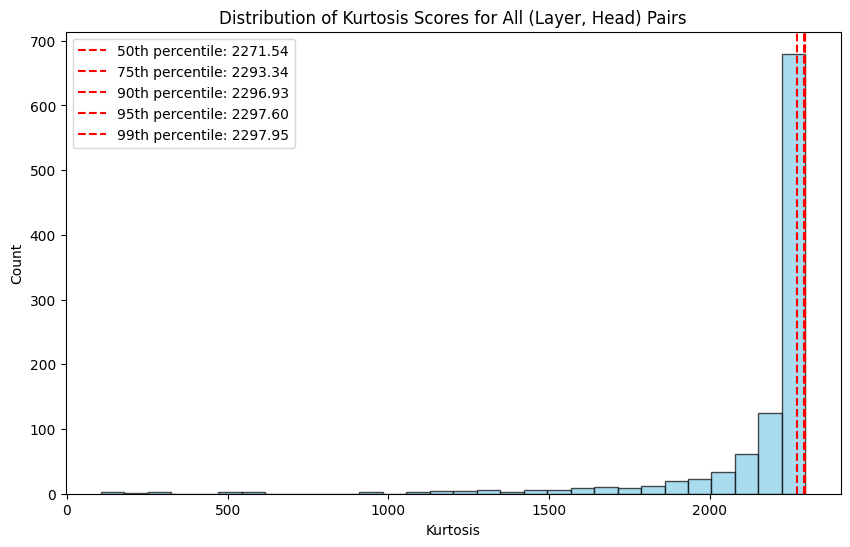

In [19]:
import matplotlib.pyplot as plt
import numpy as np
flat_kurtosis = layer_head_kurtosis.flatten()
plt.figure(figsize=(10,6))
plt.hist(flat_kurtosis, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Kurtosis Scores for All (Layer, Head) Pairs')
plt.xlabel('Kurtosis')
plt.ylabel('Count')
# Plot percentiles
for p in [50, 75, 90, 95, 99]:
    perc = np.percentile(flat_kurtosis, p)
    plt.axvline(perc, color='red', linestyle='--', label=f'{p}th percentile: {perc:.2f}')
plt.legend()
plt.show()

In [29]:
num_top = 20  # Number of heads to select
# Flatten and get indices of top 20 kurtosis values
flat_indices = np.argsort(layer_head_kurtosis.flatten())[::-1][:num_top]
layer_indices, head_indices = np.unravel_index(flat_indices, layer_head_kurtosis.shape)
top_20_heads = list(zip(layer_indices, head_indices))

print("Top 20 heads by kurtosis (layer, head):")
for i, (layer, head) in enumerate(top_20_heads):
    print(f"{i+1:2d}: Layer {layer}, Head {head}, Kurtosis: {layer_head_kurtosis[layer, head]:.3f}")

Top 20 heads by kurtosis (layer, head):
 1: Layer 4, Head 12, Kurtosis: 2297.999
 2: Layer 1, Head 20, Kurtosis: 2297.998
 3: Layer 1, Head 18, Kurtosis: 2297.997
 4: Layer 3, Head 18, Kurtosis: 2297.996
 5: Layer 4, Head 14, Kurtosis: 2297.993
 6: Layer 25, Head 20, Kurtosis: 2297.993
 7: Layer 25, Head 22, Kurtosis: 2297.992
 8: Layer 3, Head 17, Kurtosis: 2297.992
 9: Layer 29, Head 24, Kurtosis: 2297.988
10: Layer 1, Head 13, Kurtosis: 2297.954
11: Layer 29, Head 25, Kurtosis: 2297.953
12: Layer 29, Head 27, Kurtosis: 2297.952
13: Layer 29, Head 26, Kurtosis: 2297.948
14: Layer 24, Head 9, Kurtosis: 2297.927
15: Layer 1, Head 26, Kurtosis: 2297.914
16: Layer 29, Head 15, Kurtosis: 2297.910
17: Layer 24, Head 11, Kurtosis: 2297.905
18: Layer 3, Head 4, Kurtosis: 2297.900
19: Layer 7, Head 5, Kurtosis: 2297.877
20: Layer 1, Head 16, Kurtosis: 2297.872


In [31]:
top_20_heads

[(4, 12),
 (1, 20),
 (1, 18),
 (3, 18),
 (4, 14),
 (25, 20),
 (25, 22),
 (3, 17),
 (29, 24),
 (1, 13),
 (29, 25),
 (29, 27),
 (29, 26),
 (24, 9),
 (1, 26),
 (29, 15),
 (24, 11),
 (3, 4),
 (7, 5),
 (1, 16)]

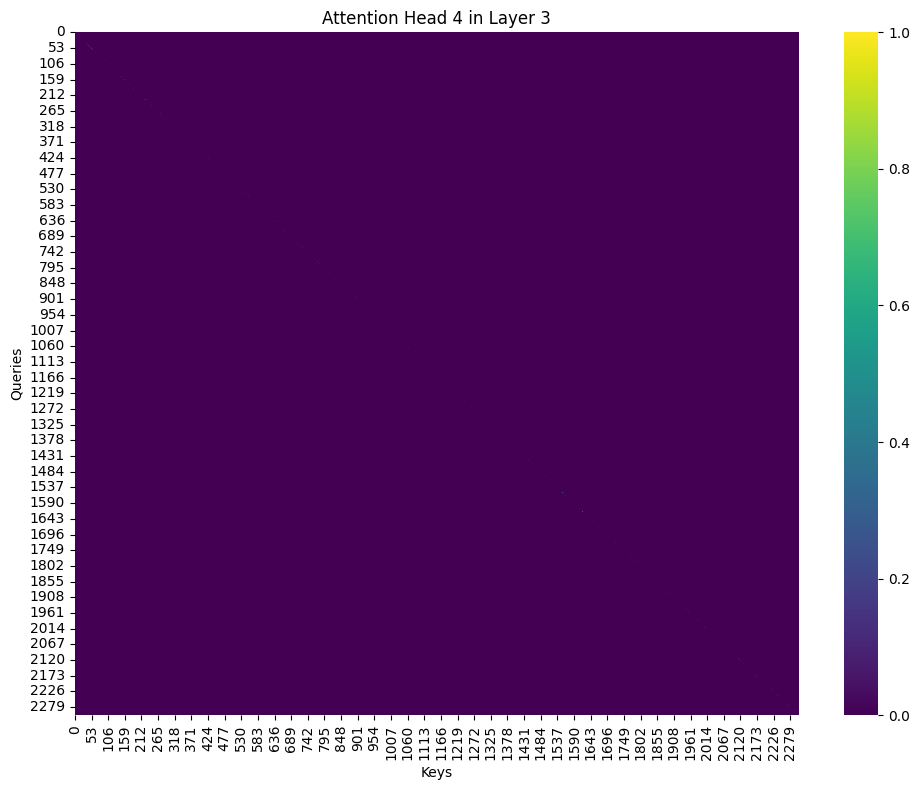

In [30]:
# Define the layer and head you want to visualize
layer_index = 3
head_index = 4

# Extract the attention pattern for the specified layer and head
if layer_index < len(attention_weights):
    layer_attention = attention_weights[layer_index]
    # Squeeze the batch dimension
    attention_pattern = layer_attention.squeeze(0)
    # Get the specific head's attention matrix and detach from the graph
    head_attention = attention_pattern[head_index].detach().numpy()

    # Create the heatmap visualization
    plt.figure(figsize=(10, 8))
    # sns.heatmap(head_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    sns.heatmap(head_attention, cmap='viridis')
    plt.title(f'Attention Head {head_index} in Layer {layer_index}')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Invalid layer index.")

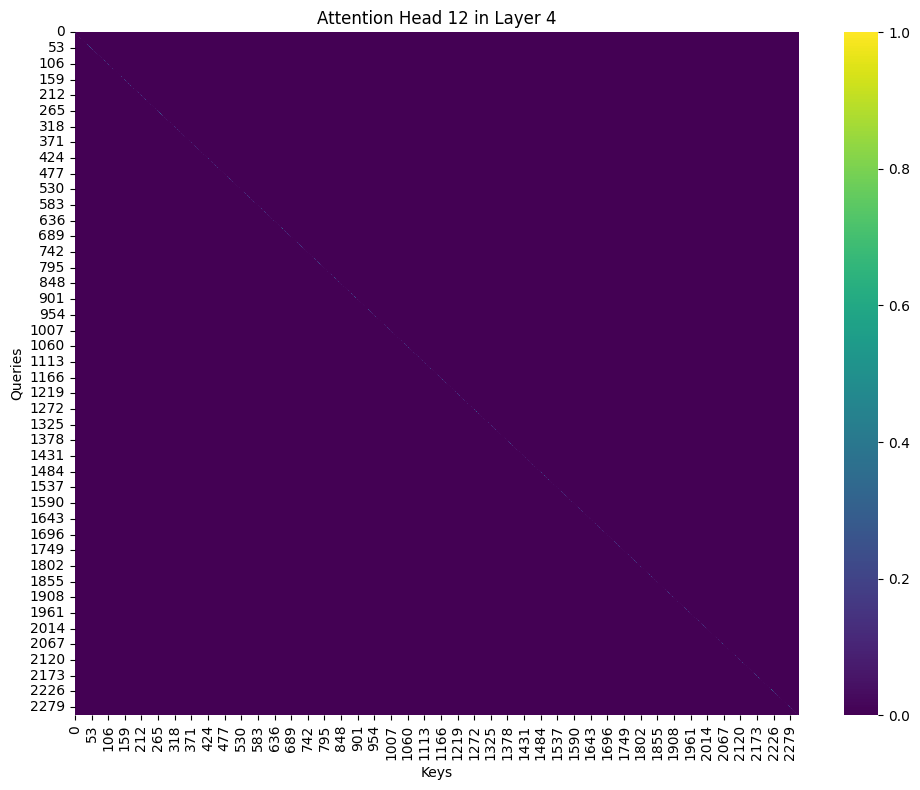

In [22]:
# Define the layer and head you want to visualize
layer_index = 4
head_index = 12

# Extract the attention pattern for the specified layer and head
if layer_index < len(attention_weights):
    layer_attention = attention_weights[layer_index]
    # Squeeze the batch dimension
    attention_pattern = layer_attention.squeeze(0)
    # Get the specific head's attention matrix and detach from the graph
    head_attention = attention_pattern[head_index].detach().numpy()

    # Create the heatmap visualization
    plt.figure(figsize=(10, 8))
    # sns.heatmap(head_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    sns.heatmap(head_attention, cmap='viridis')
    plt.title(f'Attention Head {head_index} in Layer {layer_index}')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Invalid layer index.")

In [ ]:
# Define the layer and head you want to visualize
layer_index = 10
head_index = 0

# Extract the attention pattern for the specified layer and head
if layer_index < len(attention_weights):
    layer_attention = attention_weights[layer_index]
    # Squeeze the batch dimension
    attention_pattern = layer_attention.squeeze(0)
    # Get the specific head's attention matrix and detach from the graph
    head_attention = attention_pattern[head_index].detach().numpy()

    # Create the heatmap visualization
    plt.figure(figsize=(10, 8))
    # sns.heatmap(head_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    sns.heatmap(head_attention, cmap='viridis')
    plt.title(f'Attention Head {head_index} in Layer {layer_index}')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Invalid layer index.")

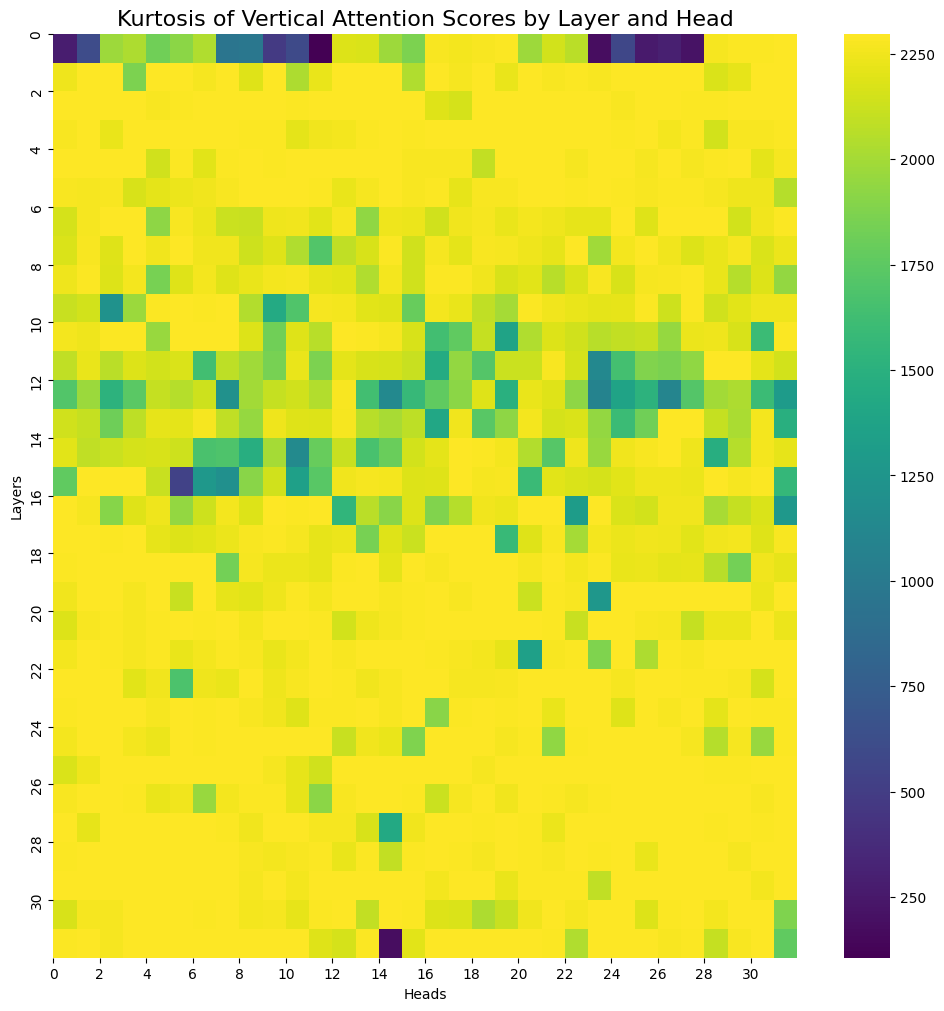

In [21]:
plt.figure(figsize=(12, 12))
sns.heatmap(layer_head_kurtosis, cmap='viridis', annot=False, fmt=".2f")
plt.title('Kurtosis of Vertical Attention Scores by Layer and Head', fontsize=16)
plt.xlabel('Heads')
plt.ylabel('Layers')
plt.xticks(np.arange(0, 32, 2), np.arange(0, 32, 2))
plt.yticks(np.arange(0, 32, 2), np.arange(0, 32, 2))
plt.show()

In [ ]:
#goes through entire chunk

In [ ]:
# Define the layer and head you want to visualize
layer_index = 15
head_index = 5
# Extract the attention pattern for the specified layer and head
if layer_index < len(attention_weights):
    layer_attention = attention_weights[layer_index]
    # Squeeze the batch dimension
    attention_pattern = layer_attention.squeeze(0)
    # Get the specific head's attention matrix and detach from the graph
    head_attention = attention_pattern[head_index].detach().numpy()

    # Create the heatmap visualization
    plt.figure(figsize=(10, 8))
    # sns.heatmap(head_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    sns.heatmap(head_attention, cmap='viridis')
    plt.title(f'Attention Head {head_index} in Layer {layer_index}')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Invalid layer index.")

In [ ]:
# Define the layer and head you want to visualize
layer_index = 31
head_index = 14
# Extract the attention pattern for the specified layer and head
if layer_index < len(attention_weights):
    layer_attention = attention_weights[layer_index]
    # Squeeze the batch dimension
    attention_pattern = layer_attention.squeeze(0)
    # Get the specific head's attention matrix and detach from the graph
    head_attention = attention_pattern[head_index].detach().numpy()

    # Create the heatmap visualization
    plt.figure(figsize=(10, 8))
    # sns.heatmap(head_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    sns.heatmap(head_attention, cmap='viridis')
    plt.title(f'Attention Head {head_index} in Layer {layer_index}')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Invalid layer index.")

In [ ]:
# Define the layer and head you want to visualize
layer_index = 0
head_index = 0
# Extract the attention pattern for the specified layer and head
if layer_index < len(attention_weights):
    layer_attention = attention_weights[layer_index]
    # Squeeze the batch dimension
    attention_pattern = layer_attention.squeeze(0)
    # Get the specific head's attention matrix and detach from the graph
    head_attention = attention_pattern[head_index].detach().numpy()

    # Create the heatmap visualization
    plt.figure(figsize=(10, 8))
    # sns.heatmap(head_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    sns.heatmap(head_attention, cmap='viridis')
    plt.title(f'Attention Head {head_index} in Layer {layer_index}')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Invalid layer index.")

In [ ]:
import copy

In [ ]:
ablated_model = copy.deepcopy(model)
layer_index_to_ablate = 31
head_index_to_ablate = 14

def ablate_attention_hook(module, input, output):
    """
    Forward hook to ablate a specific attention head's output.

    Args:
        module (nn.Module): The module to which the hook is attached.
        input (tuple): The input to the module.
        output (torch.Tensor): The output of the module.
    """
    # The output of the attention layer is typically a tuple. The first element is the
    # tensor containing the combined head outputs.
    attention_output = output[0]

    # Get the dimensions of the attention output tensor
    batch_size, sequence_length, hidden_dim = attention_output.shape

    # Find the size of each head's output dimension
    # It's hidden_dim / num_heads. This needs to be calculated from the model config.
    num_heads = module.num_heads
    head_dim = hidden_dim // num_heads

    # Reshape the output to separate heads
    # The shape becomes (batch_size, sequence_length, num_heads, head_dim)
    reshaped_output = attention_output.view(batch_size, sequence_length, num_heads, head_dim)

    # Abiate the specified head by setting its values to zero
    # Use torch.zeros_like to maintain the correct data type and device
    reshaped_output[:, :, head_index_to_ablate, :] = torch.zeros_like(
        reshaped_output[:, :, head_index_to_ablate, :]
    )

    # Reshape the tensor back to its original shape
    # This prepares it for the next module in the network
    modified_output = reshaped_output.view(batch_size, sequence_length, hidden_dim)

    # Return the modified output. It must be returned as a tuple to match the original output format.
    return (modified_output,) + output[1:]

# --- Register the hook on the specific attention layer ---
# We need to find the correct module. In most transformer models, the attention modules are
# located within the decoder layers.
# The structure is often model.base_model.layers[layer_index].self_attn
# Let's verify the structure for the DeepSeek-R1-Distill-Llama-8B model
attention_layer = ablated_model.model.layers[layer_index_to_ablate].self_attn

# Register the hook. The hook will now be triggered on every forward pass of this module.
attention_layer.register_forward_hook(ablate_attention_hook)

# --- Tokenize the input text ---
inputs = tokenizer(input_text, return_tensors="pt")

# --- Generate text with the original and ablated models ---
# The original model will generate text normally
original_output = model.generate(
    **inputs,
    max_new_tokens=20,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)
original_text = tokenizer.decode(original_output[0], skip_special_tokens=True)

# The ablated model's specified head output will be zeroed out
ablated_output = ablated_model.generate(
    **inputs,
    max_new_tokens=20,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)
ablated_text = tokenizer.decode(ablated_output[0], skip_special_tokens=True)

# --- Print the results for comparison ---
print("=" * 50)
print(f"Original Text:")
print(original_text)
print("-" * 50)
print(f"Ablated Text (Layer {layer_index_to_ablate}, Head {head_index_to_ablate}):")
print(ablated_text)
print("=" * 50)
